<a id="section-one"></a>
## Introduction

The notebook contains the implementation, training and evaluation code for the ResNet-9 model in our paper, "Automatic Blight Disease Detection in Potato (Solanum tuberosum L.) and Tomato (Solanum lycopersicum, L. 1753) Plants using Deep Learning". This notebook also contains the code used to create saliency maps presented in the thesis. 

ResNet-9 model training code in this notebook was adapted and modified from [here](https://www.kaggle.com/code/atharvaingle/plant-disease-classification-resnet-99-2/notebook)

Hyperparameter optimization was adapted and modified from [here](https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837)

## Contents
1. [Introduction](#section-one)
2. [Importing packages used](#section-two)
3. [Data exploration](#section-three)
4. [Data augmentation](#section-four)
5. [Training](#section-five)
    - 5a. [Images available for training](#subsection-five-a)
    - 5b. [Data preparation for training](#subsection-five-b)
6. [ResNet-9 model](#section-six)
    - 6a. [Functions used to build the ResNet-9 model](#subsection-six-a)
    - 6b. [ResNet-9 model implementation](#subsection-six-b)
7. [Hyperparamter tuning with Optuna](#section-seven)
    - 7a. [Visualizing the hyperparameter tuning process](#subsection-seven-a)
8. [ResNet-9 model training with optimized hyperparameters](#section-eight)
9. [Plotting training accuracies and losses](#section-nine)
    - 9a. [Training Accuracies](#subsection-nine-a)
    - 9a. [Losses](#subsection-nine-b)
10. [Test data](#section-ten)
     - 10a. [Test data preparation](#subsection-ten-a)
     - 10b. [ResNet-9 model evaluation on test data](#subsection-ten-b)
         - 10bi. [Confusion Matrix](#subsection-ten-bi)
         - 10bi. [Test accuracy and classification report](#subsection-ten-bii)
11. [Saving the model](#section-eleven)  
12. [Model Explanations (DeepShap and Saliency Maps)](#section-twelve)

<a id="section-two"></a>
## Importing packages used

In [1]:
!pip install torchsummary

In [2]:
import os                                      
import sys
import shap                                    
import torch                                   
import shutil
import optuna
import warnings
import numpy as np                             
import pandas as pd                            
import torch.nn as nn                          
from PIL import Image                          
import seaborn as sns
import matplotlib.pyplot as plt                
import torch.nn.functional as F                
from torchsummary import summary               
from torchvision.utils import make_grid        
from torch.utils.data import DataLoader        
import torchvision.transforms as transforms   
from torchvision.datasets import ImageFolder  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

<a id="section-three"></a>
## Data exploration

In [3]:
os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/')

['valid', 'train']

In [4]:
# data_dir = '/kaggle/input/dataset/idata/Image Dataset/ImageDataset/'

data_dir = '/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'
data_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'

In [5]:
# print(f"Number of image directories are {len(os.listdir(data_fpath))+len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/'))}\n")
print('Number of unique plants are 2, potato and tomato\n')
print('Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato\nHowever general classes are 3:\n\tEarly blight\n\tLate blight\n\tHealthy')

Number of unique plants are 2, potato and tomato

Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato
However general classes are 3:
	Early blight
	Late blight
	Healthy


In [6]:
# train and validation directories
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"
diseases_tr = os.listdir(train_dir)
diseases_va = os.listdir(valid_dir)


In [7]:
valid_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/'

In [8]:
diseases_tr

['late_blight', 'early_blight', 'healthy']

In [9]:
diseases = []
NumberOfDiseases = 0

for disease in diseases_tr:
    if disease != 'healthy':
        diseases.append(disease)
        NumberOfDiseases += 1
        
diseases

['late_blight', 'early_blight']

In [10]:
# Number of images for each clas in the training data
nums_train = {}
for folder in sorted(os.listdir(f"{data_dir}/train")):
    nums_train[folder] = len(os.listdir(f"/{data_dir}/train/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_training_class = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
img_per_training_class

no. of images
early_blight           3996
healthy                4011
late_blight            4002

In [11]:
# Number of images for each clas in the validation data
nums_valid = {}
for folder in sorted(os.listdir(f"{data_dir}/valid")):
    nums_valid[folder] = len(os.listdir(f"{data_dir}/valid/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_valid_class = pd.DataFrame(nums_valid.values(), index=nums_valid.keys(), columns=["no. of images"])
img_per_valid_class

no. of images
early_blight            442
healthy                 443
late_blight             446

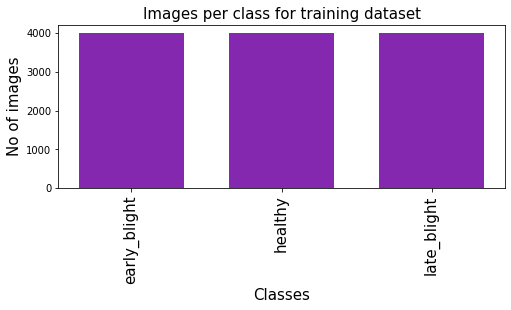

In [12]:
# plotting number of images available for each class
index = [n for n in range(3)]
plt.figure(figsize=(8, 3))
plt.bar(index, [n for n in nums_train.values()], color='#8528B0', width=0.7, align='center')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_train.keys()], fontsize=15, rotation=90)
plt.title('Images per class for training dataset', fontsize=15)

plt.savefig('/kaggle/working/number_imgs_training.png', dpi=600, bbox_inches="tight")  
plt.show()

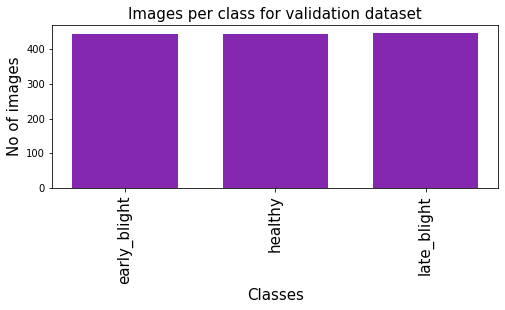

In [13]:
# plotting number of images available for each class
index = [n for n in range(3)]
plt.figure(figsize=(8, 3))
plt.bar(index, [n for n in nums_valid.values()], color='#8528B0', width=0.7) 
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_valid.keys()], fontsize=15, rotation=90)
plt.title('Images per class for validation dataset', fontsize=15)
# plt.tight_layout()
plt.savefig('/kaggle/working/number_imgs_validation.png', dpi=600, bbox_inches="tight")  
plt.show()

------------------------------------------------

<a id="section-four"></a>
## Data Augmentation

The data has already been augmented. Three augmentation techniques were used. Namely:
- Center cropping

- Gaussian blurring

- Random rotation
    

See [this notebook on github](https://github.com/Alyeko/potato-tomato-blight-disease-detection/blob/main/data%20augmentation%20for%20potato%20and%20tomato%20plant%20images.ipynb) for the code used to augment the data

------------------------

<a id="section-five"></a>
## Training

<a id="subsection-five-a"></a>
### Images available for training

In [14]:
n_train = 0
for value in nums_train.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 12009 images for training


In [15]:
n_valid = 0
for value in nums_valid.values():
    n_valid += value
print(f"There are {n_valid} images for validation")

There are 1331 images for validation


In [16]:
#Checking if here are non img files in the training data folder

In [17]:
folds = [folder for folder in os.listdir(train_dir)]
folds

['late_blight', 'early_blight', 'healthy']

In [18]:
for i in folds:
    for img in os.listdir(train_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [19]:
for i in folds:
    for img in os.listdir(valid_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [20]:
data_dir

'/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/'

In [21]:
print(f"There are {len(os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/test'))} images for test")

There are 1332 images for test


In [22]:
print(f"Training dir: {os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/')}")
print(f"All: {os.listdir('/kaggle/input/pt-leaf-data/idata/Image Dataset')}")

Training dir: ['valid', 'train']
All: ['test_data', 'ImageDataset']


In [23]:
test_dir = '/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'
# print(f"There are {len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/test_data'))} images for training")
os.listdir(test_dir)

['test']

In [24]:
for img in os.listdir(test_dir+'test'):
        if not img.endswith('.JPG'):
            print('Yes! I knew it!')

Yes! I knew it!


------------------------

<a id="subsection-five-b"></a>
### Data preparation for training 

In [25]:
print(train_dir)
print(valid_dir)

/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/train/
/kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/


In [26]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

valid = ImageFolder(valid_dir, transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

In [27]:
#Image shape
img, label = train[4590]
print(img.shape, label)

img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 1
torch.Size([3, 256, 256]) 0


We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

In [28]:
len(train.classes) #multiclass classification with 3 classes

3

In [29]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    

In [30]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

Label :late_blight(2)


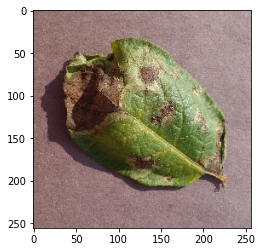

In [31]:
show_image(*train[10000])

Label :healthy(1)


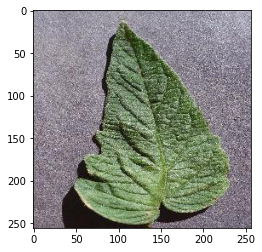

In [32]:
show_image(*train[6580])

Label :early_blight(0)


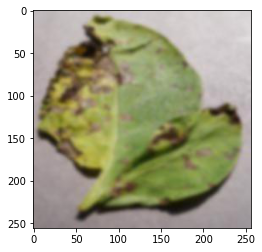

In [33]:
show_image(*train[1000])

Label :healthy(1)


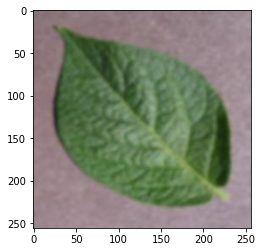

In [34]:
show_image(*train[5000])

In [35]:
print(train, '\n')
print(valid)

Dataset ImageFolder
    Number of datapoints: 12009
    Root location: /kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: /kaggle/input/pt-leaf-data/idata/Image Dataset/ImageDataset/valid/
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [36]:
# DataLoaders for training and validation
# setting the batch size
batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

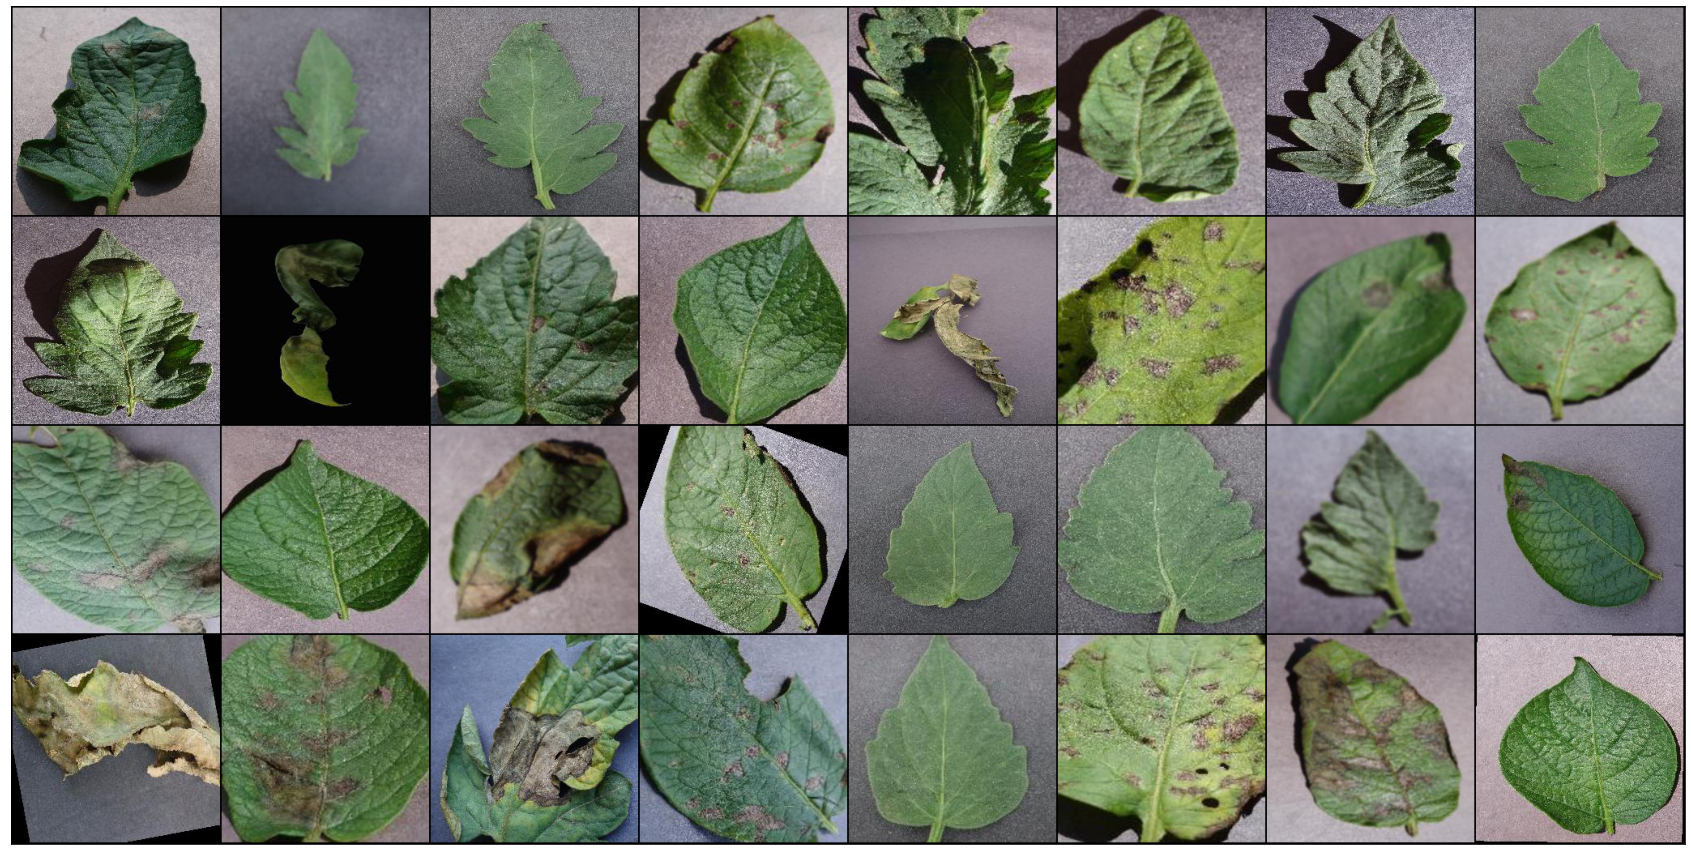

In [37]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
# Images for first batch of training
show_batch(train_dl) 

------------------------

<a id="section-six"></a>
## ResNet-9 model

<a id="subsection-six-a"></a>
### Functions used to build the ResNet-9 model 

In [38]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [41]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [42]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        train_acc = accuracy(out, labels)
        return loss
    
    def training_step_4_acc(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        train_acc = accuracy(out, labels)
        return train_acc
        
        
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_accuracy']))
        

<a id="subsection-six-b"></a>
### ResNet-9 model implementation

In [43]:
# Architecture for training
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases),
                                       nn.Softmax(dim=1))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [44]:
#defining the model 
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [45]:
#getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [46]:
#functions for training the network, added my code
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, momentum=0, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay, momentum)
         
    
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            t_acc = model.training_step_4_acc(batch)
            train_losses.append(loss)
            train_accuracies.append(t_acc)
            loss.backward()
            
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [47]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 2.79 s, sys: 389 ms, total: 3.18 s
Wall time: 6.77 s


[{'val_loss': tensor(1.0989, device='cuda:0'), 'val_accuracy': tensor(0.3289)}]

------------------------

<a id="section-seven"></a>
## Hyperparamter tuning with Optuna

In [48]:
def train_and_evaluate(param, model, train_loader, val_loader, trial):
    torch.cuda.empty_cache()
    history = []
    
    #optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #opt_func = getattr(torch.optim, param['optimizer'])
    optimizer = getattr(torch.optim, param['optimizer'])(model.parameters(), lr=param['initial_lr'], weight_decay=param['weight_decay'], momentum=param['momentum'])

        
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, param['initial_lr'], epochs=param['epochs'], steps_per_epoch=len(train_loader))

    for epoch in range(param['epochs']):
        # Training
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            t_acc = model.training_step_4_acc(batch)
            train_losses.append(loss)
            train_accuracies.append(t_acc)
            loss.backward()
            
            # gradient clipping
            if param['grad_clip']: 
                nn.utils.clip_grad_value_(model.parameters(), param['grad_clip'])
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        val_acc_last_epoch = history[-1]['val_accuracy'].item()   
        
        trial.report(val_acc_last_epoch, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        
        return val_acc_last_epoch 

In [49]:
def objective(trial):
    params = {'initial_lr': trial.suggest_loguniform('initial_lr', 0.01, 0.06),
              'optimizer': trial.suggest_categorical("optimizer", ["SGD"]),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-4, 1e-1),
              'grad_clip': trial.suggest_float('grad_clip', 0.1, 0.5),
              'epochs' : trial.suggest_int('epochs', 8, 25), 
              'momentum' : trial.suggest_float('momentum', 0, 1),
              }
    
    val_accuracy = train_and_evaluate(params, model, train_dl, valid_dl, trial)
    return val_accuracy #train_and_evaluate(params, model, train_dl, valid_dl)

In [ ]:
%%time
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

In [ ]:
best_trial = study.best_trial  

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

<a id="subsection-seven-a"></a>
### Visualizing the hyperparameter tuning process

In [ ]:
# optuna.visualization.plot_optimization_history(study)  #visualizing the tuning 
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.rcParams['figure.figsize']=[6,6]
plt.rcParams['figure.facecolor'] = 'white'
plt.tight_layout()
#plt.savefig('/kaggle/working/opt_hist_plot.png', dpi=600, bbox_inches="tight")
#plt.savefig('/kaggle/working/gblurred_sample_imgs.png', dpi=600, bbox_inches="tight")  #sample images and their corresponding andom rotations
plt.show()

In [ ]:
optuna.visualization.plot_param_importances(study) #visualizing the parameter importances  #what is the difference between this plot and the one below

---------------------

<a id="section-eight"></a>
## ResNet-9 model training with optimized hyperparameters

In [52]:
%%time 
epochs = 22
momentum = 0.42  
grad_clip = 0.13
initial_lr = 0.011
weight_decay = 0.00018
opt_func = torch.optim.SGD

history = fit_OneCycle(epochs, initial_lr, model, train_dl, valid_dl, 
                       momentum=0.42, 
                       grad_clip=0.13, 
                       weight_decay=0.00018,  
                       opt_func=opt_func)

Epoch [0], last_lr: 0.00102, train_loss: 0.7335, train_accuracy: 0.8325, val_loss: 0.6525, val_acc: 0.9033
Epoch [1], last_lr: 0.00265, train_loss: 0.6036, train_accuracy: 0.9550, val_loss: 0.6032, val_acc: 0.9501
Epoch [2], last_lr: 0.00496, train_loss: 0.5925, train_accuracy: 0.9611, val_loss: 0.5881, val_acc: 0.9653
Epoch [3], last_lr: 0.00744, train_loss: 0.5810, train_accuracy: 0.9708, val_loss: 0.6003, val_acc: 0.9489
Epoch [4], last_lr: 0.00954, train_loss: 0.5675, train_accuracy: 0.9840, val_loss: 0.5832, val_acc: 0.9690
Epoch [5], last_lr: 0.01079, train_loss: 0.5643, train_accuracy: 0.9877, val_loss: 0.5860, val_acc: 0.9650
Epoch [6], last_lr: 0.01098, train_loss: 0.5615, train_accuracy: 0.9900, val_loss: 0.5673, val_acc: 0.9851
Epoch [7], last_lr: 0.01078, train_loss: 0.5595, train_accuracy: 0.9921, val_loss: 0.5757, val_acc: 0.9747
Epoch [8], last_lr: 0.01035, train_loss: 0.5567, train_accuracy: 0.9953, val_loss: 0.5776, val_acc: 0.9725
Epoch [9], last_lr: 0.00973, train_lo

---------------------------------

<a id="section-nine"></a>
## Plotting training accuracies and losses

In [53]:
def plot_accuracies(history, epochs):
    """This function plots both training and validation accuracies of ResNet-9 model"""
    plt.rcParams['figure.figsize'] = [8, 8]
    epochs = [i for i in range(1, epochs+1)]
    val_accuracies = [x['val_accuracy'] for x in history]
    train_accuracies = [x['train_accuracy'] for x in history]
    plt.plot(epochs, train_accuracies, '-o', color='blue', label='train_loss')
    plt.plot(epochs, val_accuracies, '-o', color='green', label='validation_loss')
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
    plt.xlabel('Epochs', size=13)
    plt.ylabel('Accuracies', size=13)
    plt.grid(color='#EAE4E3')
    #plt.xticks(rotation=90)
    plt.title('Training and validation accuracies of ResNet-9', size=13)
    plt.legend()
    plt.savefig('../working/resnet9-tv-accuracies.png', dpi=600,  bbox_inches="tight")
    plt.show()
    
def plot_losses(history, epochs):
    plt.rcParams['figure.figsize'] = [8, 8]
    epochs = [i for i in range(1, epochs+1)]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss').cpu().numpy() for x in history]
    plt.plot(epochs, train_losses, '-o', color='blue', label='train_loss')
    plt.plot(epochs, val_losses, '-o', color='green', label='validation_loss')
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
    plt.xlabel('Epochs', size=13)
    plt.ylabel('Losses', size=13)
    plt.grid(color='#EAE4E3')
    #plt.xticks(rotation=90)
    plt.title('Training and validation losses of ResNet-9', size=13)
    plt.legend()
    plt.savefig('../working/resnet9-tv-losses.png', dpi=600,  bbox_inches="tight")
    plt.show()

<a id="subsection-nine-a"></a>
### Accuracies

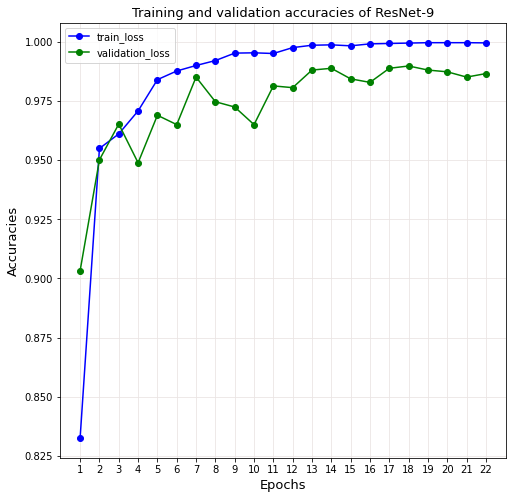

In [54]:
#Validation accuracy
plot_accuracies(history, epochs)

<a id="subsection-nine-b"></a>
### Losses

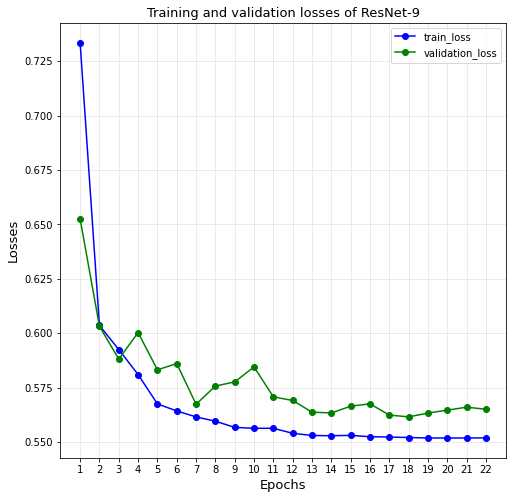

In [55]:
#Validation loss
plot_losses(history, epochs)

<a id="section-ten"></a>
## Test data 

<a id="subsection-ten-a"></a>
### Test data preparation

In [56]:
###Creating a new test dir because there was an svn file or folder found in the test dir
os.mkdir('../test_data')
os.mkdir('../test_data/test')

In [57]:
test_dir_old = test_dir
test_dir_new = '../test_data'
print(test_dir_old)
print(test_dir_new)

/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/
../test_data


In [58]:
test_dir_old

'/kaggle/input/pt-leaf-data/idata/Image Dataset/test_data/'

In [59]:
# import os
for f in os.listdir(f'{test_dir_new}/test'):
    os.remove(f'{test_dir_new}/test/{f}')

In [60]:
os.listdir(f'{test_dir_new}/test')

[]

In [61]:
for theclass in train.classes:
#     print(f"{test_dir_new}/test/{theclass}")
    os.mkdir(f"{test_dir_new}/test/{theclass}")

In [62]:
os.listdir(f'{test_dir_new}/test')

['healthy', 'early_blight', 'late_blight']

In [63]:
'tomato_late_23.JPG'.split('_')[1] + '_blight'

'late_blight'

In [64]:
os.listdir(f'{test_dir_new}/test')

['healthy', 'early_blight', 'late_blight']

In [65]:
###Moving file from old test dir to new test dir
num_moved = 0
for img in os.listdir(test_dir_old+'/test'):
    if img.endswith('.JPG'):
        if img.split('_')[1] !='healthy':
            theclass = img.split('_')[1] + '_blight'
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        elif img.split('_')[1] =='healthy':
            theclass = img.split('_')[1] 
            #print(theclass)
            shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        
        num_moved += 1
    elif img.endswith('svn'):
        print('not going to move you!')
print(f"Number of files moved: {num_moved}")

not going to move you!
Number of files moved: 1331


In [66]:
len(os.listdir(f'{test_dir_new}/test')) #3 folders which are early_blight, healthy and late_blight

3

In [67]:
len(os.listdir('../test_data/test')) #files have been moved

3

In [68]:
os.listdir(f"{test_dir_new}")

['test']

In [69]:
#Testing model on test data
test = ImageFolder('../test_data/test', transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

In [70]:
test

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: ../test_data/test
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [71]:
os.listdir(test_dir_new + '/test')

['healthy', 'early_blight', 'late_blight']

In [72]:
early = os.listdir(test_dir_new + '/test/healthy')
healthy = os.listdir(test_dir_new + '/test/early_blight')
late = os.listdir(test_dir_new + '/test/late_blight')

test_images = sorted(early+healthy+late) # since images in test folder are not in alphabetical order
print(len(test_images))

1331


In [73]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [74]:
len(test)

1331

In [75]:
img, label = test[-1]
label

2

In [76]:
print(len(test_images))
print(len(test))

1331
1331


<a id="subsection-ten-b"></a>
### ResNet-9 model evaluation on test data

Label: tomato_late_207.JPG , Predicted: late_blight


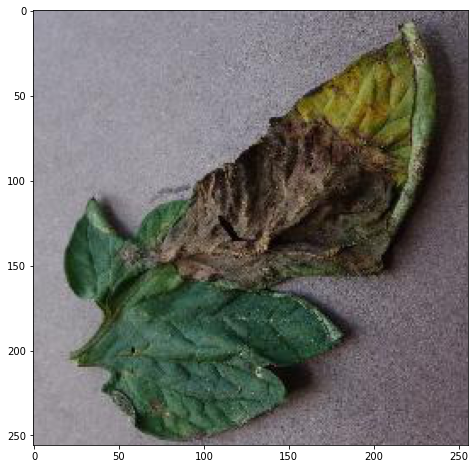

In [77]:
# predicting first image
img, label = test[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[1000], ', Predicted:', predict_image(img, model))

In [78]:
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [79]:
predictions =[] #code adapted from https://stackoverflow.com/questions/63647547/how-to-find-confusion-matrix-and-plot-it-for-image-classifier-in-pytorch
targets = []
for images, labels in test_loader_r:
    images, labels = images.cuda(), labels.cuda()
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

In [80]:
train.classes

['early_blight', 'healthy', 'late_blight']

In [81]:
targets[:5]

[0, 2, 0, 0, 0]

In [82]:
predictions[:5]

[0, 2, 0, 0, 0]

<a id="subsection-ten-bi"></a>
#### Confusion matrix

In [83]:
cf_matrix = confusion_matrix(targets, predictions)
cf_matrix

array([[435,   0,   7],
       [  0, 250,   0],
       [  2,   1, 636]])

In [84]:
class_names = train.classes
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

early_blight  healthy  late_blight
early_blight           435        0            7
healthy                  0      250            0
late_blight              2        1          636

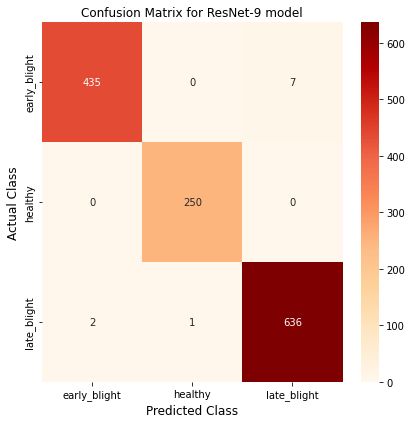

In [88]:
plt.figure(figsize=(6, 6))  

#Create heatmap
sns.heatmap(dataframe, annot=True, cbar=True,cmap="OrRd",fmt="d") #'purples', 'PuRd'
plt.title("Confusion Matrix for ResNet-9 model", size=12), plt.tight_layout()
 
plt.ylabel("Actual Class", size=12), 
plt.xlabel("Predicted Class",  size=12)
plt.tight_layout()
plt.savefig('../working/cmatrxresnet9.png', dpi=600,  bbox_inches="tight")
plt.show()

<a id="subsection-ten-bii"></a>
#### Test accuracy and classification report

In [86]:
print("Test Accuracy : {}".format(accuracy_score(targets, predictions)))
print("\nConfusion Matrix : ")
print(confusion_matrix(targets, predictions))
print("\nClassification Report :")
print(classification_report(targets, predictions, target_names=train.classes))

Test Accuracy : 0.9924868519909842

Confusion Matrix : 
[[435   0   7]
 [  0 250   0]
 [  2   1 636]]

Classification Report :
              precision    recall  f1-score   support

early_blight       1.00      0.98      0.99       442
     healthy       1.00      1.00      1.00       250
 late_blight       0.99      1.00      0.99       639

    accuracy                           0.99      1331
   macro avg       0.99      0.99      0.99      1331
weighted avg       0.99      0.99      0.99      1331



<a id="section-eleven"></a>
## Saving the model

In [89]:
# saving to the kaggle working directory ###check this again  
PATH1 = './resnet9-mdlsd.pth'  
torch.save(model.state_dict(), PATH1)

PATH2 = './resnet9-mdl.pth' 
torch.save(model, PATH2)

---------------------------------

<a id="section-twelve"></a>
## Model Explanations (DeepShap and Saliency Maps)

In [88]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [89]:
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [90]:
train.classes

['early_blight', 'healthy', 'late_blight']

In [91]:
# since shuffle=True, this is a random sample of test data
images, targets =  next(iter(test_loader_r))
BACKGROUND_SIZE = 20
background_images = images[:BACKGROUND_SIZE]
background_targets = targets[:BACKGROUND_SIZE].cpu().numpy()
#increase the size after you've fixed everything 

test_images = images[BACKGROUND_SIZE:BACKGROUND_SIZE+9]
test_targets = targets[BACKGROUND_SIZE:BACKGROUND_SIZE+9].cpu().numpy()
def show_attributions(model):
    # predict the probabilities of the digits using the test images
    output = model(test_images.to(device))
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.cpu().numpy() 

    expl = shap.DeepExplainer(model, background_images)
    train_classes = ['early_blight', 'healthy', 'late_blight']
    for i in range(0, len(test_images)):
        warnings.filterwarnings('ignore')
        
        torch.cuda.empty_cache()
        ti = test_images[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.cpu().numpy(), 1, -1), 1, 2) #.cpu().numpy()?

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        allaxes[0].set_title('Actual: {}, Pred: {}'.format(train_classes[test_targets[i]], train_classes[pred_np[i][0]]), fontsize=10)
        
        
        prob = output[i].detach().cpu().numpy()
        for x in range(1, len(allaxes)-1):
            #allaxes[x].set_title('{}'.format(train_classes[x-1]), fontsize=10)
            allaxes[x].set_title('{}({:.2%})'.format(train_classes[x-1], prob[x-1]), fontsize=10)
            allaxes[0].imshow(test_images[i].cpu().permute(1, 2, 0))       
         

        plt.show()

In [92]:
feature_attributions = show_attributions(model)
feature_attributions

RuntimeError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 15.90 GiB total capacity; 12.98 GiB already allocated; 207.75 MiB free; 14.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF